In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime, time

### Exploring smaller datasets of 100k ratings

In [4]:
ratings = pd.read_csv('./Raw Data/ratings_small.csv')
tags = pd.read_csv('./Raw Data/tags_small.csv')
movies = pd.read_csv('./Raw Data/movies_small.csv')

### Column lists:

ratings: ['userId', 'movieId', 'rating', 'timestamp']

tags: ['userId', 'movieId', 'tag', 'timestamp']

movies : ['movieId', 'title', 'genres']

In [5]:
dfs = [(ratings, 'ratings'), (tags,'tags'), (movies, 'movies')]

for df,name in dfs:
    print(f'{name}')
    print(f'Columns: {list(df.columns)}')
    has_id = 'True' if 'movieId' in list(df.columns) else 'False'
    print(f'Has movieId: {has_id}')
    #print(f'Has movieId: {'True' if 'movieId' in list(df.columns) else 'False'}')
    print(f'shape: {df.shape}')
    print(f'nulls: ')
    print(f'{df.isnull().sum()}')
    
    print('')

ratings
Columns: ['userId', 'movieId', 'rating', 'timestamp']
Has movieId: True
shape: (100836, 4)
nulls: 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

tags
Columns: ['userId', 'movieId', 'tag', 'timestamp']
Has movieId: True
shape: (3683, 4)
nulls: 
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

movies
Columns: ['movieId', 'title', 'genres']
Has movieId: True
shape: (9742, 3)
nulls: 
movieId    0
title      0
genres     0
dtype: int64



# Sentiment analysis on tags???? unless that basically equals rating???

In [6]:
#1589 unique tags, which equals 43% of the dataset
tags['tag'].nunique() / tags.shape[0]

0.431441759435243

### Let's explore these dataframe variables to better understand which we will want for modeling

Self explanatory dataframes are: ratings, movies

the tags dataframe has a column 'tag' which has a descriptor. examples are: 'fun', 'epic', 'pacing', 'dinosaurs', 'lawn mower'. our datasets did not come with a data dictionary, but these words could come from imdb comments. 

## Initial cleaning
1) merge ratings and movies on movieId

2) explore number of ratings through sparsity measures

In [7]:
df = pd.merge(ratings, movies, on='movieId', how='left')
#timestamp is not needed
#df.drop(columns=['timestamp'], inplace=True)
df.head(5)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [8]:
#turn timestamp into datetime for EDA on ranking days (are people more forigiving on the weekend?)
df['datetime'] = np.nan
for row in list(range(0,df.shape[0])):
    df['datetime'][row] = datetime.fromtimestamp(df['timestamp'][row]).strftime("%A, %B %d, %Y %I:%M:%S")

/var/folders/l_/zmpwb1k10n73190173cr1g300000gn/T/ipykernel_1087/2420889981.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'][row] = datetime.fromtimestamp(df['timestamp'][row]).strftime("%A, %B %d, %Y %I:%M:%S")
/Users/jacqueline/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [9]:
df['day'] = np.nan
for row in list(range(0,df.shape[0])):
    df['day'][row] = datetime.fromtimestamp(df['timestamp'][row]).strftime("%A")

/var/folders/l_/zmpwb1k10n73190173cr1g300000gn/T/ipykernel_1087/3012312403.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'][row] = datetime.fromtimestamp(df['timestamp'][row]).strftime("%A")


## Titles contain their year released wrapped in parentheses. 
All but 17 rows have parenthesis. This represents 99.98% of the movies. 

In [10]:
count = 0
print('Movies without years: ')
for title in df['title']:
    if '(' in title:
        count+=1
    else: print(title)

Movies without years: 
Black Mirror
The Adventures of Sherlock Holmes and Doctor Watson
Maria Bamford: Old Baby
Generation Iron 2
Ready Player One
Babylon 5
Ready Player One
Nocturnal Animals
Cosmos
Ready Player One
The OA
Hyena Road
Moonlight
Ready Player One
Babylon 5
Paterson
Cosmos


In [11]:
print(f'Titles without parentheses: {df.shape[0] - count}')
print(f'Percent without parentheses: {count / df.shape[0]}')

Titles without parentheses: 17
Percent without parentheses: 0.9998314094172716


In [12]:
#movie labels have their year in parenthesis - let's examine!
#df['year'] = df['title'].str.extract('\(([^)]+)', expand=True) 
#df['year'] = df['title'].str[-5:-1]
df['year'] = df['title'].str.extract('.*\((.*)\).*',expand = False)
#df['year'] = df[df['title'].str.find('(')+1:df['title'].str.find(')')]
#df['year'] = re.search('\(([^)]+)', df['title'].str)
#df['year'] = df['title'].str.split('(', 1)[1].split(')')[0]
#df.head()

In [13]:
#clean up some year value, originally '2006-2007'
df['year'][16913]='2007'

/var/folders/l_/zmpwb1k10n73190173cr1g300000gn/T/ipykernel_1087/2254397721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'][16913]='2007'


In [14]:
#we have nulls for the same movies listed above without parentheses
#let's go ahead and delete these 17 rows
df[df['year'].isnull()]['title']
df['year'].isnull().sum()
df.dropna(inplace=True)

Genre's are messy. There are 951 unique genres... I initially wanted to take the initial genres, assuming it was the most prominent genre, and only use that to categorize movies. However, genres are listed alphabetically.

# one hot encode genres???

In [15]:
df.genres.nunique()

951

A sparsity of .982 is too high. We probably have a good amount of users with a minimal number of ratings. There are two approaches to reducing sparsity. One is removing users with minimal # ratings. The second is removing movies with minimal ratings. In order to determine these thresholds, let's look into the numbers and then filter through groupby's.

In [16]:
#Check sparsity of matrix
ratings_count = len(df['rating'])
users_count = len(df['userId'].unique())
movies_count = len(df['movieId'].unique())

sparse = 1 - (ratings_count / (users_count*movies_count))
sparse

0.9829821819213007

Figure out solid marker for minimum amounts of ratings per user and ratings per movies

In [17]:
df.copy().groupby('userId')['movieId'].count().describe()

count     610.000000
mean      165.277049
std       269.413735
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2697.000000
Name: movieId, dtype: float64

In [18]:
df.copy().groupby('movieId')['userId'].count().describe()

count    9712.000000
mean       10.380869
std        22.412608
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: userId, dtype: float64

In [19]:
def description(grouped_column, column2):
    print(grouped_column)
    print(f'nunique: {df[grouped_column].nunique()}')
    print(f'min: {df.copy().groupby(grouped_column)[column2].count().min()}')
    print(f'max: {df.copy().groupby(grouped_column)[column2].count().max()}')
    print('***********')

description('movieId', 'userId')
description('userId', 'movieId')

movieId
nunique: 9712
min: 1
max: 329
***********
userId
nunique: 610
min: 20
max: 2697
***********


Check sparsity test on new df with less NaNs

In [20]:
user_min = 30
movie_min = 5

df2 = df.copy().groupby('userId').filter(lambda x: len(x)>user_min)
df2 = df2.copy().groupby('movieId').filter(lambda x: len(x)>movie_min)

In [21]:
ratings_count = len(df2['rating'])
users_count = len(df2['userId'].unique())
movies_count = len(df2['movieId'].unique())

sparse = 1 - (ratings_count / (users_count*movies_count))
sparse
print(f' sparse: {sparse}, df length: {df.shape[0]}, df2 length: {df2.shape[0]}')
print(f"movie unique: df: {df['movieId'].nunique()}, df2: {df2['movieId'].nunique()}")
print(f"user unique: df: {df['userId'].nunique()}, df2: {df2['userId'].nunique()}")

 sparse: 0.9470045256480186, df length: 100819, df2 length: 85694
movie unique: df: 9712, df2: 3247
user unique: df: 610, df2: 498


# *****Not enough change in sparsity. Will try more combinations.

In [22]:
user_min = 150
movie_min = 10

df2 = df.copy().groupby('userId').filter(lambda x: len(x)>user_min)
df2 = df2.copy().groupby('movieId').filter(lambda x: len(x)>movie_min)

In [23]:
ratings_count = len(df2['rating'])
users_count = len(df2['userId'].unique())
movies_count = len(df2['movieId'].unique())

sparse = 1 - (ratings_count / (users_count*movies_count))
print(f' sparse: {sparse}, df length: {df.shape[0]}, df_test length: {df2.shape[0]}')
print(f"movie unique: df: {df['movieId'].nunique()}, df_test: {df2['movieId'].nunique()}")
print(f"user unique: df: {df['userId'].nunique()}, df_test: {df2['userId'].nunique()}")

 sparse: 0.8286031887187957, df length: 100819, df_test length: 53966
movie unique: df: 9712, df_test: 1820
user unique: df: 610, df_test: 173


##### While we reviewed column statistics earlier, it's also important to understand value counts AKA popularity and the count ranges our data possesses

In [24]:
df2.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres',
       'datetime', 'day', 'year'],
      dtype='object')

In [25]:
df2['year'].unique()

array(['1995', '1996', '1994', '1977', '1993', '1990', '1989', '1991',
       '1940', '1939', '1941', '1968', '1963', '1971', '1951', '1979',
       '1992', '1986', '1982', '1975', '1980', '1987', '1981', '1983',
       '1960', '1984', '1933', '1985', '1974', '1922', '1997', '1998',
       '1976', '1942', '1967', '1959', '1978', '1973', '1988', '1999',
       '1964', '1962', '1965', '1969', '2000', '1970', '1952', '1961',
       '1954', '1946', '1955', '1957', '2001', '1937', '2002', '2003',
       '2004', '2005', '2006', '1972', '1966', '1949', '1931', '1936',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '1958', '1944', '1950', '1953', '1956',
       '1938', '1948', '1927', '1934', '1947'], dtype=object)

In [26]:
def normal_counts(column):
    print(column)
    print(df2[column].value_counts(ascending=False, normalize=True))
    print("""
    *******************
    """)
    
normal_columns = ('rating', 'year', 'genres', 'day', 'movieId', 'userId')

for column in normal_columns:
    normal_counts(column)

rating
4.0    0.276730
3.0    0.190083
3.5    0.143331
5.0    0.123652
4.5    0.090668
2.0    0.067765
2.5    0.059148
1.0    0.022570
1.5    0.015584
0.5    0.010470
Name: rating, dtype: float64

    *******************
    
year
2000    0.051996
1999    0.050624
1995    0.046418
2001    0.045807
1997    0.042101
          ...   
1936    0.000315
1938    0.000278
1947    0.000259
1922    0.000241
1934    0.000241
Name: year, Length: 85, dtype: float64

    *******************
    
genres
Comedy                             0.064967
Drama                              0.048809
Comedy|Romance                     0.037968
Comedy|Drama|Romance               0.029537
Action|Adventure|Sci-Fi            0.028092
                                     ...   
Adventure|Drama|Romance            0.000204
Adventure|Drama|Sci-Fi|Thriller    0.000204
Adventure|Drama|Fantasy|Romance    0.000204
Action|Animation|Mystery|IMAX      0.000204
Action|Fantasy|Thriller|IMAX       0.000204
Name: genres, Length: 

### Initial EDA

In [27]:
df2.groupby('title').size().sort_values(ascending=False)

title
Forrest Gump (1994)                                      142
Matrix, The (1999)                                       135
Star Wars: Episode IV - A New Hope (1977)                134
Star Wars: Episode V - The Empire Strikes Back (1980)    128
Pulp Fiction (1994)                                      127
                                                        ... 
Barcelona (1994)                                          11
Cutting Edge, The (1992)                                  11
Barb Wire (1996)                                          11
Bank Job, The (2008)                                      11
Dukes of Hazzard, The (2005)                              11
Length: 1820, dtype: int64

In [28]:
df2.groupby('title').size().sort_values(ascending=False).head(10)

title
Forrest Gump (1994)                                                               142
Matrix, The (1999)                                                                135
Star Wars: Episode IV - A New Hope (1977)                                         134
Star Wars: Episode V - The Empire Strikes Back (1980)                             128
Pulp Fiction (1994)                                                               127
Star Wars: Episode VI - Return of the Jedi (1983)                                 123
Shawshank Redemption, The (1994)                                                  119
Silence of the Lambs, The (1991)                                                  118
Back to the Future (1985)                                                         116
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    116
dtype: int64

/Users/jacqueline/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


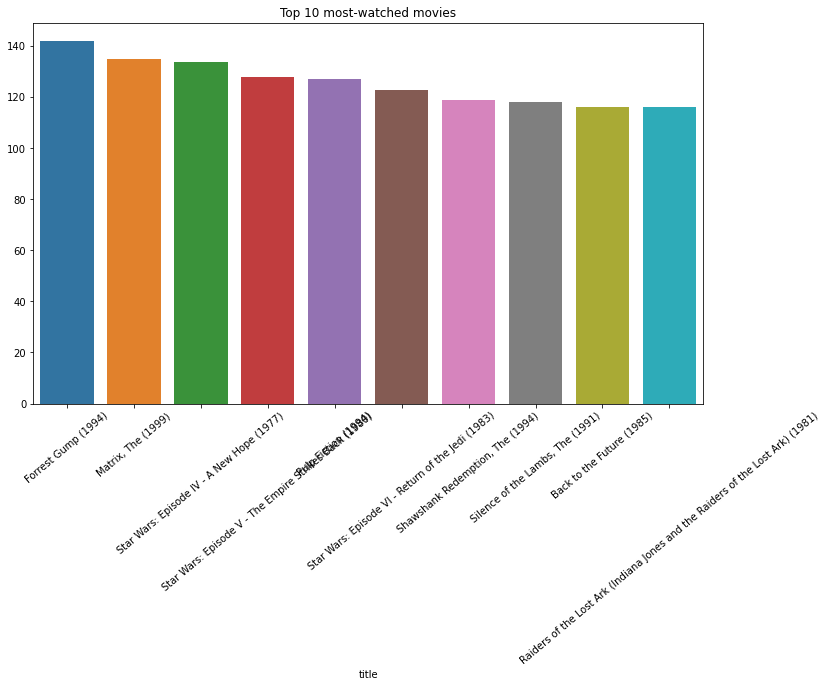

In [29]:
#Plot the top 10 most watched movies
plt.figure(figsize=(12,7))
topmovies = df2.groupby('title').size().sort_values(ascending=False).head(10)
sns.barplot(topmovies.index, topmovies.values)
plt.title('Top 10 most-watched movies')
plt.xticks(rotation=40);

In [30]:
df2['year'] = df2['year'].astype(int)

In [31]:
df2.describe()

,userId,movieId,rating,timestamp,year
count,53966.000000,53966.000000,53966.000000,5.396600e+04,53966.000000
mean,326.987344,15349.660453,3.539673,1.221127e+09,1994.412667
std,183.297838,29186.421275,0.996632,1.975067e+08,13.564973
min,1.000000,1.000000,0.500000,8.346915e+08,1922.000000
25%,177.000000,1240.000000,3.000000,1.049076e+09,1989.000000
50%,318.000000,2791.000000,3.500000,1.187320e+09,1997.000000
75%,480.000000,6552.000000,4.000000,1.435994e+09,2003.000000
max,610.000000,176371.000000,5.000000,1.537799e+09,2017.000000


In [32]:
print(df2['year'].nunique())
print(df2['year'].unique())

85
[1995 1996 1994 1977 1993 1990 1989 1991 1940 1939 1941 1968 1963 1971
 1951 1979 1992 1986 1982 1975 1980 1987 1981 1983 1960 1984 1933 1985
 1974 1922 1997 1998 1976 1942 1967 1959 1978 1973 1988 1999 1964 1962
 1965 1969 2000 1970 1952 1961 1954 1946 1955 1957 2001 1937 2002 2003
 2004 2005 2006 1972 1966 1949 1931 1936 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 1958 1944 1950 1953 1956 1938 1948 1927 1934
 1947]


/Users/jacqueline/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


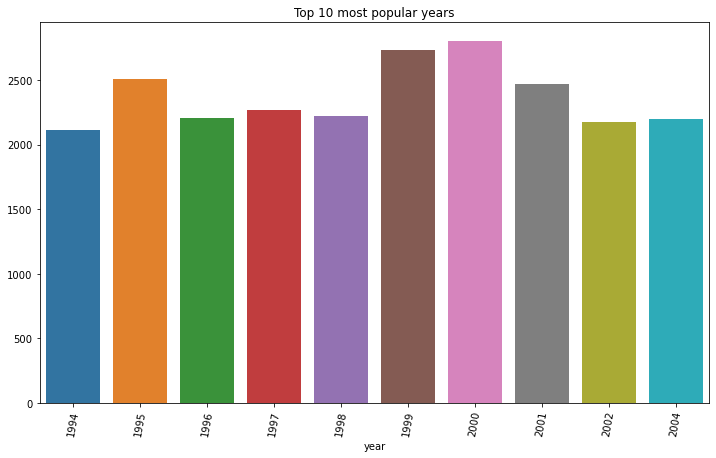

In [33]:
#Top 10 Years with the most movies produced.
plt.figure(figsize=(12,7))
topyear = df2.groupby('year').size().sort_values(ascending=False).head(10)
sns.barplot(topyear.index, topyear.values)
plt.title('Top 10 most popular years')
plt.xticks(rotation=80);

<BarContainer object of 19 artists>

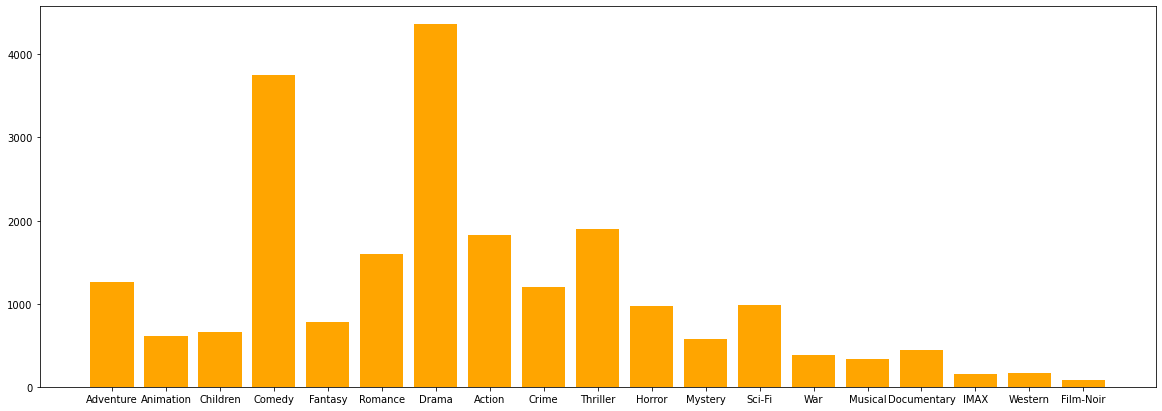

In [34]:
plt.figure(figsize=(20,7))
genrelist = movies['genres'].apply(lambda genrelist_movie : str(genrelist_movie).split("|"))
genres_count = {}

for genrelist_movie in genrelist:
    for genre in genrelist_movie:
        if(genres_count.get(genre,False)):
            genres_count[genre]=genres_count[genre]+1
        else:
            genres_count[genre] = 1       
genres_count.pop("(no genres listed)")
plt.bar(genres_count.keys(),genres_count.values(),color='orange')

In [35]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


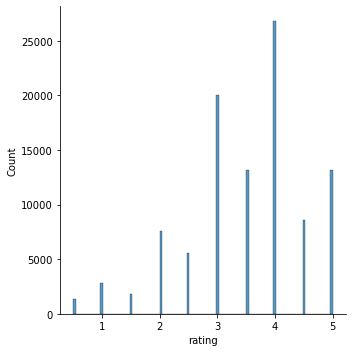

In [36]:
sns.displot(data=ratings, x="rating")

In [37]:
ratings_movies = ratings.copy()
ratings_movies.drop(columns='timestamp', inplace=True)
ratings_movies.drop(columns='movieId', inplace=True)

In [38]:
ratings_users_agg = ratings_movies.groupby('userId').agg([np.size, np.mean])

In [39]:
ratings_users_mean = pd.DataFrame(ratings_movies.copy().groupby('userId')['rating'].mean())
ratings_users_count = pd.DataFrame(ratings_movies.copy().groupby('userId')['rating'].count())

ratings_mean_count = pd.merge(ratings_users_mean, ratings_users_count, on='userId', how='inner')
ratings_mean_count.rename(columns={'rating_x':'mean_rating', 'rating_y':'count_rating'}, inplace=True)

In [40]:
ratings_mean_count[['count_rating']].describe()

,count_rating
count,610.000000
mean,165.304918
std,269.480584
min,20.000000
25%,35.000000
50%,70.500000
75%,168.000000
max,2698.000000


Text(0.5, 1.0, '# Ratings vs Mean Rating')

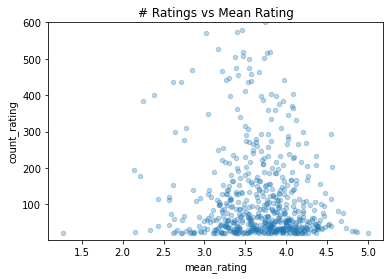

In [41]:
ratings_mean_count.plot.scatter(x='mean_rating', y='count_rating', alpha=.3)
plt.ylim(2,600)
plt.title('# Ratings vs Mean Rating')

In [42]:
nicey = df[df['userId']==251][['rating','title','genres','datetime']]
nicey

,rating,title,genres,datetime
37447,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,"Monday, August 08, 2016 01:27:48"
37448,4.5,Taxi Driver (1976),Crime|Drama|Thriller,"Monday, August 08, 2016 01:21:38"
37449,5.0,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller,"Monday, August 08, 2016 01:18:42"
37450,5.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,"Monday, August 08, 2016 01:18:37"
37451,5.0,"Shawshank Redemption, The (1994)",Crime|Drama,"Monday, August 08, 2016 01:17:30"
37452,5.0,Forrest Gump (1994),Comedy|Drama|Romance|War,"Monday, August 08, 2016 01:28:18"
37453,5.0,Schindler's List (1993),Drama|War,"Monday, August 08, 2016 01:17:32"
37454,5.0,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,"Monday, August 08, 2016 01:18:15"
37455,5.0,Fargo (1996),Comedy|Crime|Drama|Thriller,"Monday, August 08, 2016 01:20:29"
37456,5.0,Reservoir Dogs (1992),Crime|Mystery|Thriller,"Monday, August 08, 2016 01:20:03"


In [43]:
meany = df[df['userId']==442][['rating','title','genres','datetime']]
meany
#plt.figure(figsize=(10,7))
#sns.barplot(y = meany['rating'], x=meany['title'], palette='autumn')

,rating,title,genres,datetime
68317,2.5,"Jungle Book, The (1994)",Adventure|Children|Romance,"Monday, March 12, 2012 09:54:58"
68318,1.5,Englishman Who Went Up a Hill But Came Down a ...,Comedy|Romance,"Monday, March 12, 2012 09:55:38"
68319,2.0,Rudy (1993),Drama,"Monday, March 12, 2012 09:55:06"
68320,1.0,Heavy Metal (1981),Action|Adventure|Animation|Horror|Sci-Fi,"Monday, March 12, 2012 09:55:45"
68321,1.5,"Aristocats, The (1970)",Animation|Children,"Monday, March 12, 2012 09:55:12"
68322,1.0,"Sex, Lies, and Videotape (1989)",Drama,"Monday, March 12, 2012 09:55:56"
68323,1.0,"Right Stuff, The (1983)",Drama,"Monday, March 12, 2012 09:56:17"
68324,0.5,Patton (1970),Drama|War,"Monday, March 12, 2012 09:54:20"
68325,0.5,I Know What You Did Last Summer (1997),Horror|Mystery|Thriller,"Monday, March 12, 2012 09:56:15"
68326,1.0,Dangerous Liaisons (1988),Drama|Romance,"Monday, March 12, 2012 09:56:10"


In [44]:
ratings_mean_count[ratings_mean_count['mean_rating']>4.7]

,mean_rating,count_rating
userId,,
25,4.807692,26
30,4.735294,34
53,5.000000,20
251,4.869565,23
515,4.846154,26


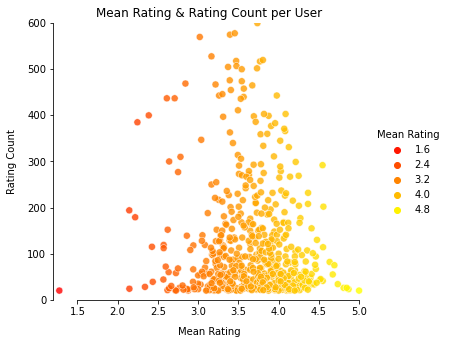

In [51]:
a = sns.relplot(data=ratings_mean_count, x='mean_rating', y='count_rating', hue='mean_rating',
            palette='autumn', s=50, alpha=.8).set(title='Mean Rating & Rating Count per User')
a.set_axis_labels('pct_hesitant_02-24-22', 'uninsured_pct', labelpad=10)
a.legend.set_title("Mean Rating")
#a.fig.suptitle('Mean Rating & Rating Count per User', fontweight='bold')
a.figure.set_size_inches(6.5, 4.5)
plt.ylim(0, 600)
a.ax.margins(.02)
a.despine(trim=True)
a.set_axis_labels('Mean Rating', 'Rating Count', labelpad=10)
plt.savefig('Visuals/rating_count_user', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight')

In [40]:
df_day = df2[['rating','day']].groupby('day').mean()
df_day['count'] = df2[['rating','day']].groupby('day').count()

In [76]:
df_day = df_day.sort_values(by='count', ascending=False)

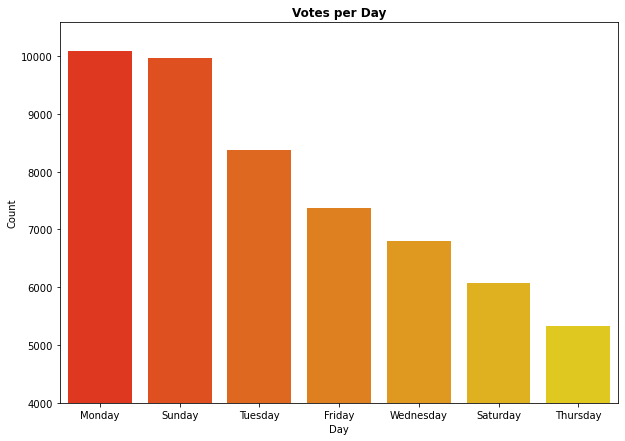

In [79]:
plt.figure(figsize=(10,7))
sns.barplot(y = df_day['count'], x=df_day.index, palette='autumn')
plt.title('Votes per Day', fontweight='bold')
plt.xlabel('Day')
plt.ylabel('Count')
plt.ylim(4000,)
#plt.savefig('Visuals/movie_day_counts', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight')

Genre counts

In [42]:
genrelabels = set()
for i in df2['genres'].str.split('|').values:
    genrelabels = genrelabels.union(set(i))

In [43]:
#Create function that counts how many movies there are of each genre 
def genre_counts(df, col, labels):
    count = dict()
    for i in labels: count[i] = 0
    for value in df[col].str.split('|'):
        if type(value) == float and pd.isnull(value): continue
        for i in value: 
            if pd.notnull(i): count[i] += 1
    return count     

In [44]:
genre_count = genre_counts(df2, 'genres', genrelabels)

In [45]:
genres = pd.DataFrame(list(genre_count.items()),columns = ['genre','count'])

In [46]:
genres = genres.sort_values(by=['count'], ascending=False)

/Users/jacqueline/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


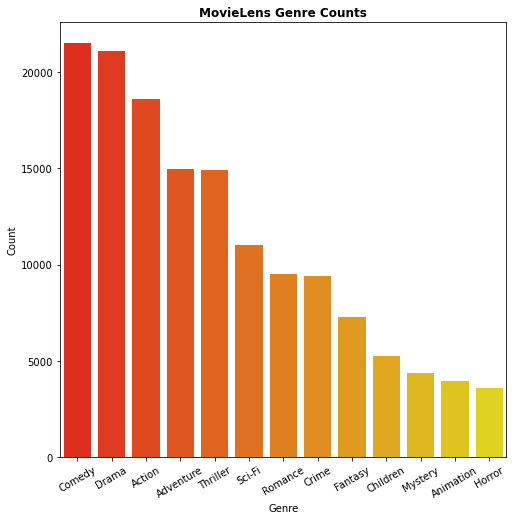

In [54]:
plt.figure(figsize=(8,8))
sns.barplot(genres['genre'][0:13], genres['count'][0:13], palette='autumn')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('MovieLens Genre Counts', fontweight='bold')
plt.xticks(rotation=30);
#plt.savefig('Visuals/movie_genre_counts', facecolor='w', transparent=False, dpi = 1000, bbox_inches='tight')

In [49]:
#Create columns for each genre to indicate T/F
for genre in genrelabels:
    df2[genre] = df2['genres'].apply(lambda x: genre in x)

In [50]:
#Boolean values for each genre across every movie in the data frame.
pd.set_option('max_columns', None)
df2.head()

,userId,movieId,rating,timestamp,title,genres,datetime,day,year,Documentary,Children,Film-Noir,Horror,Sci-Fi,Mystery,Action,IMAX,Musical,Romance,Comedy,Thriller,Crime,Fantasy,Animation,War,Western,Adventure,Drama
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"Sunday, July 30, 2000 02:45:03",Sunday,1995,False,True,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,True,False
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,"Sunday, July 30, 2000 02:20:47",Sunday,1995,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,"Sunday, July 30, 2000 02:37:04",Sunday,1995,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,"Sunday, July 30, 2000 03:03:35",Sunday,1995,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"Sunday, July 30, 2000 02:48:51",Sunday,1995,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False


In [51]:
matrix = df2.drop(['userId', 'movieId', 'rating', 'genres', 'year', 'datetime', 'day', 'timestamp'], axis=1)
matrix.head()

,title,Documentary,Children,Film-Noir,Horror,Sci-Fi,Mystery,Action,IMAX,Musical,Romance,Comedy,Thriller,Crime,Fantasy,Animation,War,Western,Adventure,Drama
0,Toy Story (1995),False,True,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,True,False
1,Grumpier Old Men (1995),False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False
2,Heat (1995),False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False
3,Seven (a.k.a. Se7en) (1995),False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False
4,"Usual Suspects, The (1995)",False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False


In [52]:
#matrix.to_csv('genre_boo.csv')

In [53]:
#Export the resulting data to a csv file 
#df2.to_csv('clean_df')